<a href="https://colab.research.google.com/github/guivahl/spotify-tracks/blob/main/colab/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Realização dos imports e instalação das bibliotecas necessarias

In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
!pip install pycaret
import pycaret


###Download dos dados obtidos através do script em node


In [3]:
!wget https://raw.githubusercontent.com/guivahl/spotify-tracks/main/All_data.csv

--2021-11-15 12:02:12--  https://raw.githubusercontent.com/guivahl/spotify-tracks/main/All_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877475 (1.8M) [text/plain]
Saving to: ‘All_data.csv.1’

All_data.csv.1      100%[===================>]   1.79M  --.-KB/s    in 0.03s   

2021-11-15 12:02:12 (51.6 MB/s) - ‘All_data.csv.1’ saved [1877475/1877475]



###Pré-processamento de dados

In [4]:
df = pd.read_csv('All_data.csv', sep=',')
df.describe()

,popularity,duration_ms,track_number,album_total_tracks,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,8146.000000,9.950000e+03,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,4106.000000,8779.000000,9950.000000,9950.000000,6376.0,9950.000000,9950.000000,9950.000000,9950.000000
mean,47.245642,2.095383e+05,6.405226,13.090553,0.295992,0.630937,0.685278,0.114830,5.908190,0.223246,-6.253207,1.0,0.093081,125.947216,3.956181,0.563959
std,19.531157,7.167411e+04,8.271113,14.072209,0.263425,0.147296,0.175274,0.254219,3.315766,0.194768,2.747597,0.0,0.092968,28.486055,0.281592,0.243451
min,1.000000,2.054600e+04,1.000000,1.000000,0.000002,0.088700,0.032200,0.000001,1.000000,0.013400,-25.469000,1.0,0.022300,35.636000,1.000000,0.017400
25%,36.000000,1.692450e+05,1.000000,2.000000,0.054350,0.539000,0.574000,0.000011,2.000000,0.099500,-7.716750,1.0,0.038000,103.031000,4.000000,0.374000
50%,48.000000,1.968460e+05,3.000000,10.000000,0.222000,0.644000,0.703000,0.000280,6.000000,0.142000,-5.921000,1.0,0.054700,126.823500,4.000000,0.589000
75%,62.000000,2.311730e+05,9.000000,20.000000,0.505000,0.736000,0.823000,0.029575,9.000000,0.294000,-4.343000,1.0,0.103000,146.034250,4.000000,0.758000
max,100.000000,1.524621e+06,105.000000,121.000000,0.995000,0.984000,0.999000,0.990000,11.000000,0.993000,1.252000,1.0,0.892000,215.510000,5.000000,0.984000


Como podemos ver pela descrição dos dados, a coluna 'mode' não possui alteração nos dados, com o valor sempre sendo 1, sendo assim, optamos por retira-la já que não ensinará nada para o modelo.

In [5]:
df = df.drop(['mode'], axis=1)

Aqui verificamos todos os valores null das variaveis e decidimos formas diferentes de trata-las para cada caso.

In [6]:
nans = df.loc[:, df.isnull().sum() > 0].isnull().sum()
nans

name                  20
popularity          1804
explicit            8355
album_name            39
instrumentalness    5844
key                 1171
dtype: int64

Em algumas colunas os valores null ultrapassaram mais de 50% de todos os valores, sendo assim optamos por retira-las.
Também optamos em colocar o valor 'None' para nulls em variáveis categoricas.

In [7]:
df = df.drop(['explicit', 'instrumentalness'], axis=1)
df['name'].fillna('None', inplace=True)
df['album_name'].fillna('None', inplace=True)
nans = df.loc[:, df.isnull().sum() > 0].isnull().sum()
nans

popularity    1804
key           1171
dtype: int64

Em variáveis numéricas colocamos a média da variável.

In [8]:
for col in nans.index:
  df[col].fillna(df[col].mean(), inplace=True)

In [9]:
df.dtypes

id                     object
name                   object
popularity            float64
duration_ms             int64
track_number            int64
type                   object
release_date           object
album_name             object
album_total_tracks      int64
artist_id              object
artist_name            object
acousticness          float64
danceability          float64
energy                float64
key                   float64
liveness              float64
loudness              float64
speechiness           float64
tempo                 float64
time_signature          int64
valence               float64
dtype: object

Retiramos release_date por ser um tipo data.

In [10]:
df = df.drop(['release_date'], axis=1)

###Encoder
Para podermos utilizar essas variáveis categóricas, aplicamos a técnica de Ordinal Encoder, que basicamente ordena as string por ordem de aparição nos dados, sendo assim conseguimos identificar artistas com mais de uma aparição nos dados.

In [11]:
enc = OrdinalEncoder()
enc.fit(df[['id', 'name', 'type', 'album_name', 'artist_id', 'artist_name']])
df[['id', 'name', 'type', 'album_name', 'artist_id', 'artist_name']] = enc.transform(df[['id', 'name', 'type', 'album_name', 'artist_id', 'artist_name']])
df.describe()

,id,name,popularity,duration_ms,track_number,type,album_name,album_total_tracks,artist_id,artist_name,acousticness,danceability,energy,key,liveness,loudness,speechiness,tempo,time_signature,valence
count,9950.000000,9950.000000,9950.000000,9.950000e+03,9950.000000,9950.0,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000
mean,4616.508141,3754.055980,47.245642,2.095383e+05,6.405226,0.0,1989.612764,13.090553,1038.714472,1047.720302,0.295992,0.630937,0.685278,5.908190,0.223246,-6.253207,0.093081,125.947216,3.956181,0.563959
std,2667.825677,2174.070451,17.671923,7.167411e+04,8.271113,0.0,1155.005986,14.072209,609.910760,594.147252,0.263425,0.147296,0.175274,3.114526,0.194768,2.747597,0.092968,28.486055,0.281592,0.243451
min,0.000000,0.000000,1.000000,2.054600e+04,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000002,0.088700,0.032200,1.000000,0.013400,-25.469000,0.022300,35.636000,1.000000,0.017400
25%,2305.250000,1854.250000,39.000000,1.692450e+05,1.000000,0.0,1000.250000,2.000000,528.000000,524.000000,0.054350,0.539000,0.574000,4.000000,0.099500,-7.716750,0.038000,103.031000,4.000000,0.374000
50%,4604.500000,3762.500000,47.245642,1.968460e+05,3.000000,0.0,2011.500000,10.000000,1058.500000,1028.000000,0.222000,0.644000,0.703000,5.908190,0.142000,-5.921000,0.054700,126.823500,4.000000,0.589000
75%,6934.750000,5638.750000,59.000000,2.311730e+05,9.000000,0.0,2993.750000,20.000000,1566.750000,1610.000000,0.505000,0.736000,0.823000,8.000000,0.294000,-4.343000,0.103000,146.034250,4.000000,0.758000
max,9238.000000,7523.000000,100.000000,1.524621e+06,105.000000,0.0,4060.000000,121.000000,2063.000000,2063.000000,0.995000,0.984000,0.999000,11.000000,0.993000,1.252000,0.892000,215.510000,5.000000,0.984000


Depois de descrevermos de novo os dados(agora com variáveis categóricas ordenadas), descobrimos que a coluna 'type' não altera suas informações, optamos por retira-la da mesma forma que fizemos com 'mode'.

In [12]:
df = df.drop(['type'], axis=1)

Selecionamos os dados como entrada e saída.

In [14]:
y = df['popularity'].copy()
x = df.drop(['popularity'], axis=1)
y = y.astype(int)

Dividimos os dados para treino e teste.

In [15]:
df2 = x.copy()
df2['popularity'] = y
df2 = df2.drop(['id', 'artist_id'], axis=1)
df_train, df_test = train_test_split(df2, test_size=0.3)

###Treino de modelos
Utilizamos neste projeto a biblioteca Pycaret, que facilita todo o processo para criação e avaliação de modelos.

In [18]:
from pycaret.regression import *

reg = setup(data = df_train, 
              target = 'popularity', 
              train_size = 0.7)

,Description,Value
0,session_id,8189
1,Target,popularity
2,Original Data,"(6965, 17)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4875, 19)"


Aqui treinamos varios modelos e avaliamos eles para selecionarmos os que mais se adequaram para o problema, sendo eles:

1.   Light Gradient Boosting Machine
2.   Random Forest Regressor
3.   Extra Trees Regressor



In [19]:
compare_models(round=4, sort='mse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,10.9061,206.0306,14.3260,0.3543,0.5003,0.7893,0.236
rf,Random Forest Regressor,11.0892,216.5272,14.6936,0.3203,0.5089,0.7972,4.065
et,Extra Trees Regressor,10.9178,220.4448,14.8271,0.3078,0.5082,0.7829,1.670
gbr,Gradient Boosting Regressor,11.7970,235.7860,15.3376,0.2594,0.5251,0.8348,1.280
ada,AdaBoost Regressor,13.4871,275.0306,16.5764,0.1340,0.5392,0.8179,0.507
ridge,Ridge Regression,12.8352,277.9067,16.6587,0.1259,0.5550,0.8888,0.016
lr,Linear Regression,12.8350,277.9234,16.6593,0.1258,0.5550,0.8887,0.316
lar,Least Angle Regression,12.8350,277.9244,16.6593,0.1258,0.5550,0.8887,0.019
br,Bayesian Ridge,12.8375,277.9450,16.6598,0.1258,0.5550,0.8890,0.021
en,Elastic Net,13.3013,300.5390,17.3254,0.0548,0.5666,0.9064,0.018


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=8189, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Criamos o modelo de lightgbm.

In [20]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.8716,207.8959,14.4186,0.3564,0.5213,0.9011
1,10.7601,203.7730,14.2749,0.3320,0.5201,0.9171
2,11.4099,223.5488,14.9515,0.3260,0.4950,0.6712
3,10.4108,177.4421,13.3207,0.4148,0.4139,0.4546
4,11.5894,237.5654,15.4132,0.3443,0.6085,1.2819
5,11.9471,249.5272,15.7964,0.2973,0.5781,1.0486
6,10.3875,187.3399,13.6872,0.3329,0.4850,0.7502
7,10.2564,181.4601,13.4707,0.4244,0.4325,0.5799
8,11.6152,222.4518,14.9148,0.3234,0.5128,0.7733
9,9.8135,169.3021,13.0116,0.3914,0.4358,0.5153


Fazemos a procura dos melhores hiper-parametros para o modelo.

In [21]:
lightgbm_tuned = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.6591,199.2597,14.1159,0.3831,0.5090,0.8723
1,10.7001,203.0475,14.2495,0.3344,0.5133,0.9059
2,11.2182,221.7305,14.8906,0.3315,0.4923,0.6641
3,10.3085,171.8500,13.1092,0.4332,0.4005,0.4256
4,11.4903,238.2936,15.4368,0.3423,0.5990,1.2330
5,11.4488,233.9601,15.2958,0.3411,0.5660,1.0018
6,10.5446,191.5657,13.8407,0.3179,0.4886,0.7815
7,9.9658,176.0953,13.2701,0.4414,0.4244,0.5510
8,11.1235,208.6972,14.4464,0.3652,0.4967,0.7135
9,10.0357,179.4032,13.3941,0.3551,0.4319,0.4985


Plotamos os residuos do modelo já tunado.

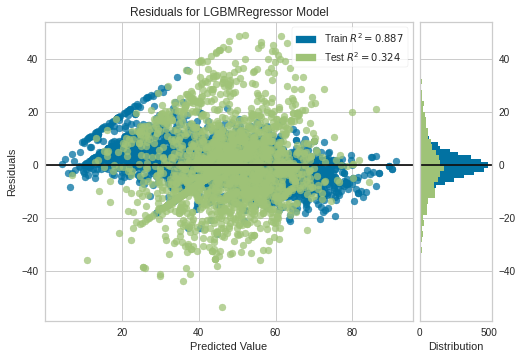

In [22]:
plot_model(lightgbm_tuned, plot='residuals')

E temos até um retorno de quais variáveis foram mais importantes para a predição de popularidade (parece que quem canta é realmente a variável mais importante pra uma música ser popular).

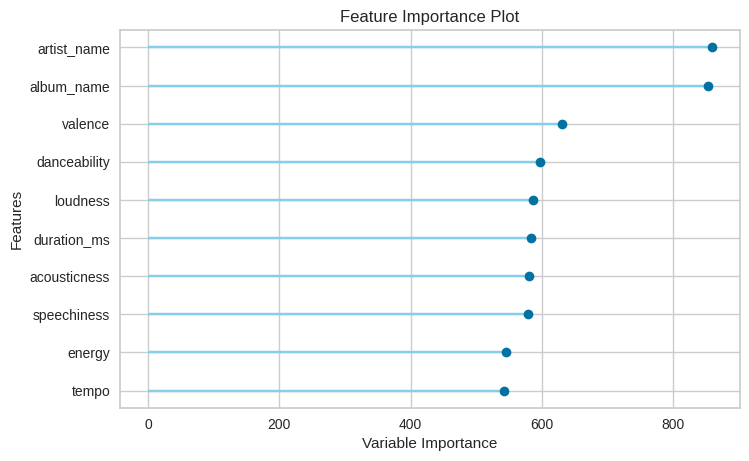

In [23]:
plot_model(lightgbm_tuned, 'feature')

E então finalizamos o modelo criado.

In [24]:
final_lightgbm = finalize_model(lightgbm_tuned)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='popularity', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                colsample_bytree=1.0, feature_fraction=1.0,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, min_child_samples=31,
                                min_child_weight=0.001, min_split_gain=0.6,
                 

Fazemos a mesma coisa para o Random Forest.

In [50]:
rf = create_model('rf')
rf_tuned = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,11.7667,237.0993,15.3980,0.2660,0.5434,0.9347
1,11.6541,233.1049,15.2678,0.2359,0.5436,0.9618
2,12.3446,255.7866,15.9933,0.2288,0.5227,0.7310
3,11.5654,212.8576,14.5896,0.2980,0.4479,0.5100
4,12.5790,273.5200,16.5384,0.2450,0.6322,1.3343
5,13.0408,283.5373,16.8386,0.2015,0.6074,1.1396
6,11.4596,230.4879,15.1818,0.1793,0.5198,0.8335
7,11.6526,225.2993,15.0100,0.2854,0.4657,0.6351
8,12.3173,251.3698,15.8546,0.2354,0.5419,0.8099
9,10.6575,202.3281,14.2242,0.2727,0.4684,0.5715


E para o Extre Trees.

In [ ]:
et = create_model('et')
et_tuned = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,11.0943,227.3937,15.0796,0.2960,0.5420,0.9170
1,10.9320,221.6939,14.8894,0.2733,0.5310,0.9434
2,11.0451,230.0401,15.1671,0.3064,0.5062,0.6994
3,10.6937,194.8078,13.9574,0.3575,0.4179,0.4419
4,11.4635,256.0496,16.0015,0.2932,0.6116,1.2217
5,11.5947,247.8040,15.7418,0.3021,0.5756,1.0061
6,10.6018,210.5928,14.5118,0.2501,0.5061,0.8003
7,10.2316,193.5584,13.9125,0.3860,0.4284,0.5271
8,11.6830,238.1610,15.4325,0.2756,0.5268,0.7719
9,9.8383,184.3470,13.5774,0.3373,0.4365,0.5001


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:10:55
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min


Utilizamos uma técnica de Ensemble chamada Blend, esta técnica basicamente faz os modelos votarem em um resultado predito pelo modelo, e o resultado que for mais votado é selecionado como a saída.

In [ ]:
blended = blend_models(estimator_list=[final_lightgbm, rf_tuned, et])

In [ ]:
plot_model(blended, plot='residuals')